## Functions

In [164]:
def lasso_confusion(mat, cols, C, norm_method, name, figsize=(7, 7)):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    n_splits = 3
    confusion = np.zeros((n_classes, n_classes))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if norm_method == 'SMOTE':
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
        elif norm_method == 'bal_weights':
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=42)
        elif norm_method == None:
            clf = LogisticRegression(
                penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)  
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        confusion += confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))
    confusion = normalize(confusion, axis=1, norm='l1')
    print(accuracy)

    # Create confusion matrix
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion = confusion = pd.DataFrame(
        confusion, columns=col_names, index=col_names)
    #confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=figsize)
    rc = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat = sns.heatmap(confusion, annot=True, linewidths=.1,
                       fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)
    return None

In [165]:
def lasso_coefs(mat, cols, C, norm_method):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    # print(X,y)
    if norm_method == 'SMOTE':
        X, y = SMOTE().fit_resample(X, y)
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
    if norm_method == 'bal_weights':
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=42)
    clf.fit(X, y)
    coefs = clf.coef_
    coefs = np.transpose(coefs)
    coefs = pd.DataFrame(coefs, columns=clf.classes_, index=cols)
    # print(clf.coef_)
    return coefs

In [166]:
def lasso_vanilla(mat, cols, Cs):
    X=mat[cols].values
    y=mat['Functional_Category'].values
    #print(X,y)
    accuracy={}
    for C in Cs:        
        skf = StratifiedKFold(n_splits=3, shuffle=True)
        accuracy_per_fold=[]
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train, y_train=SMOTE().fit_resample(X_train, y_train)
            clf=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
            clf.fit(X_train,y_train)
            y_hat=clf.predict(X_test)
            accuracy_per_fold.append(balanced_accuracy_score(y_test, y_hat))
        accuracy[C]=sum(accuracy_per_fold)/len(accuracy_per_fold)
    print (accuracy)
    #return accuracy

## With log2FC and q-val- mycobrowser

In [68]:
%reset -f

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [70]:
lfc_mb_filt = pd.read_csv('../data/standardized_data/cleaned/lfc_mb_filt.csv')
qval_mb_filt = pd.read_csv(
    '../data/standardized_data/cleaned/qval_mb_filt.csv')

In [71]:
# replaced values of qval lower than 0.05 with 0.05. Then divided log2FC by qval^beta
def lasso_inv_p(betas, Cs, lfc, qval, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values
    # replace values lower than 0.05 with 0.05
    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    # print(X,y)
    accuracy = pd.DataFrame(index=betas, columns=Cs, dtype='float')
    for b in betas:
        X = X/np.power(qval, b)
        for C in Cs:
            # print(b)
            skf = StratifiedKFold(n_splits=3, shuffle=True)
            accuracy_per_fold = []
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
                clf = LogisticRegression(
                    penalty='l1', solver='liblinear', multi_class='ovr', C=C)
                clf.fit(X_train, y_train)
                y_hat = clf.predict(X_test)
                accuracy_per_fold.append(accuracy_score(y_test, y_hat))
            accuracy.loc[b, C] = sum(accuracy_per_fold)/len(accuracy_per_fold)
    plt.figure()
    heat = sns.heatmap(accuracy, annot=True, linewidths=.1, fmt='1.2f')
    heat.set(xlabel='Cs', ylabel='betas',
             title='Accuracy with LR on log2FC w pval')
    return None

In [72]:
betas = [0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
Cs = [0.005, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

In [73]:
(lfc_mb_filt.columns == qval_mb_filt.columns).all()

True

In [74]:
lfc_mb_filt.head()

,ORF,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,zhang_DETA-NO_pH_7.0_vs_zhang_pH_7.0_no_NO_control,zhang_Fe_1.5mM_vs_zhang_Fe_450uM,zhang_Trp_Rescue_vs_zhang_in_vitro_control_Rescue,zhang_Tyloxapol_pH_6.5_vs_zhang_Tyloxapol_pH_4.5,zhang_Tyloxapol_pH_6.5_vs_zhang_pcit_pH_4.5,zhang_mhcii_mouse_d10_vs_zhang_wt_mouse_d10,zhang_mhcii_mouse_d45_vs_zhang_wt_mouse_d45,zhang_wt_mouse_d10_vs_zhang_input_library,zhang_wt_mouse_d45_vs_zhang_input_library,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,-0.31,1.09,-2.13,0.51,0.41,1.30,-0.49,-1.26,-2.25,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.89,-2.36,-1.89,2.90,2.20,-4.05,0.30,0.69,-3.55,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,0.23,-1.51,4.80,-2.90,-2.05,-2.93,0.87,3.70,3.67,information pathways


In [75]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

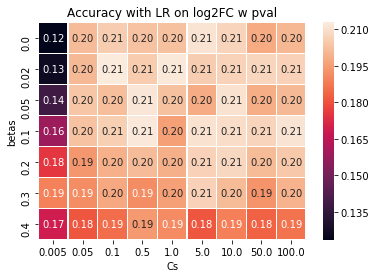

In [76]:
lasso_inv_p(betas, Cs, lfc_mb_filt, qval_mb_filt, value_cols)

In [77]:
def lasso_min_p(lfc, qval, C, value_cols):
    X = lfc[value_cols].values
    y = lfc['Functional_Category'].values
    # replace values lower than 0.05 with 0.05
    qval = qval[value_cols].apply(lambda x: np.where(x < 0.05, 0.05, x))
    qval = qval[value_cols].values
    # print(X,y)
    accuracy = []
    X = X*(1-qval)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        clf = LogisticRegression(
            penalty='l1', solver='liblinear', multi_class='ovr', C=C)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_hat))
    print(accuracy)
    # return accuracy

In [78]:
lasso_min_p(lfc_mb_filt, qval_mb_filt, 10, value_cols)

[0.20285423037716616, 0.17262512768130744, 0.18730808597748208]


## With lfc only - mycobrowser

In [79]:
%reset -f 

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize

%matplotlib inline

In [82]:
lfc_mb_filt = pd.read_csv('../data/standardized_data/cleaned/lfc_mb_filt.csv')

In [83]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

[0.20285423037716616, 0.22063329928498468, 0.20368474923234392]


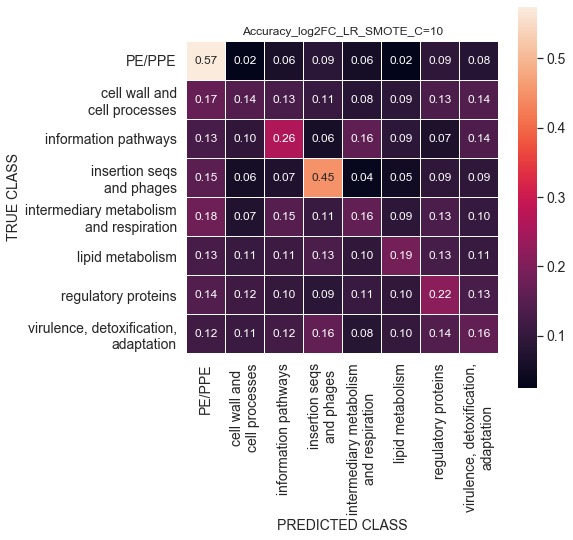

In [86]:
lasso_confusion(lfc_mb_filt, value_cols, C=10, norm_method='SMOTE', name='Accuracy_log2FC_LR_SMOTE_C=10')

[0.2558613659531091, 0.2604698672114402, 0.2712384851586489]


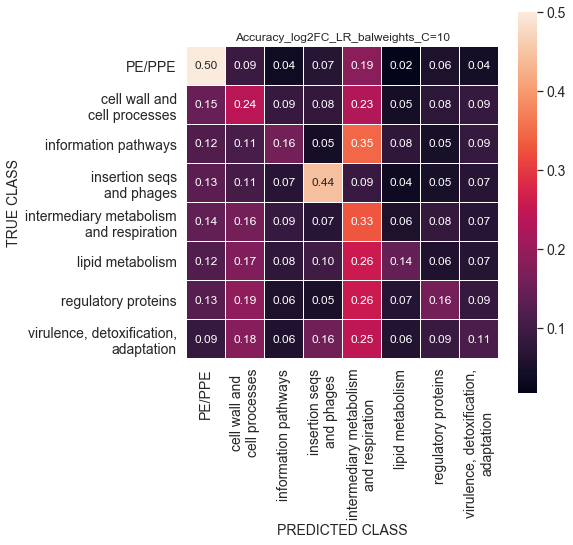

In [88]:
lasso_confusion(lfc_mb_filt,value_cols, C=10, norm_method='bal_weights', name='Accuracy_log2FC_LR_balweights_C=10')

[0.34658511722731905, 0.338100102145046, 0.3203684749232344]


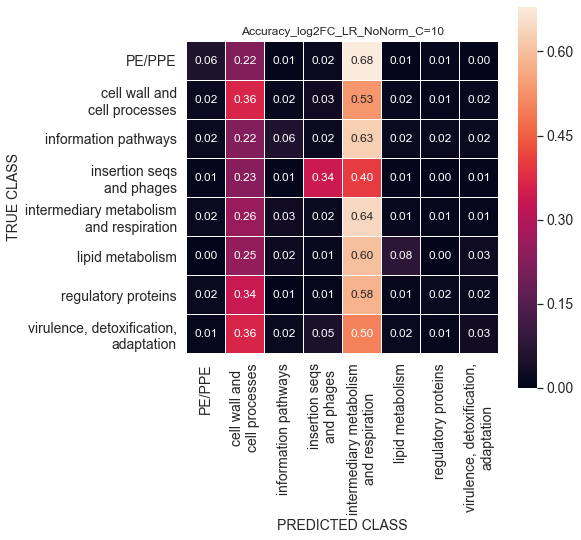

In [89]:
lasso_confusion(lfc_mb_filt,value_cols, C=10, norm_method=None, name='Accuracy_log2FC_LR_NoNorm_C=10')

In [90]:
lfc_mb_filt.Functional_Category.value_counts()

intermediary metabolism and respiration    933
cell wall and cell processes               771
lipid metabolism                           270
information pathways                       242
virulence, detoxification, adaptation      220
regulatory proteins                        197
PE/PPE                                     162
insertion seqs and phages                  142
Name: Functional_Category, dtype: int64

In [96]:
lasso_coefs(lfc_mb_filt, value_cols, 10,'SMOTE').to_csv('results/coefs_mb_lfc_SMOTE_C10.csv')

## With binary

In [99]:
%reset -f 

In [120]:
import pandas as pd
import pathlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
bin_mb_filt=pd.read_csv('../data/standardized_data/cleaned/bin_mb_filt.csv')

In [113]:
binary_data_cols=[col for col in bin_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

In [116]:
lasso_vanilla(bin_mb_filt, binary_data_cols, Cs=[0.005,0.05,0.1,1,10,50])

{0.005: 0.125, 0.05: 0.18099973313756393, 0.1: 0.1754651481969283, 1: 0.19412354160828907, 10: 0.20045998466497594, 50: 0.19760704162740753}


[0.1488277268093782, 0.1470888661899898, 0.1699078812691914]


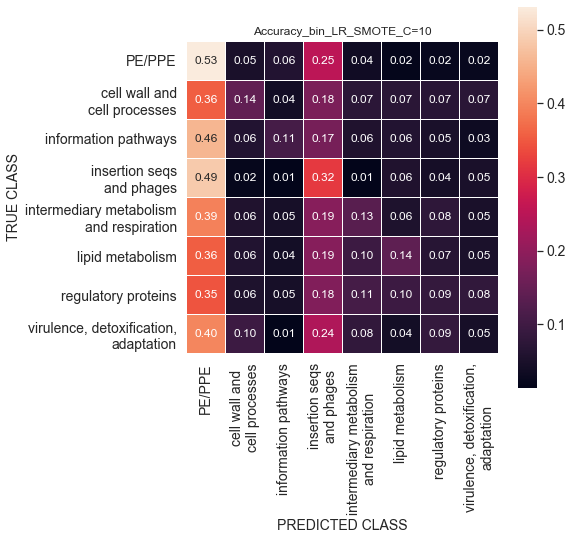

In [121]:
lasso_confusion(bin_mb_filt, binary_data_cols, C=10, norm_method='SMOTE', name='Accuracy_bin_LR_SMOTE_C=10')

[0.291539245667686, 0.2839632277834525, 0.3132036847492323]


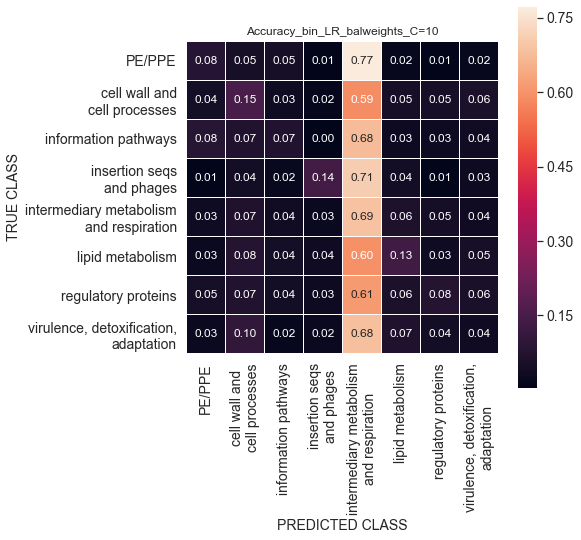

In [123]:
lasso_confusion(bin_mb_filt, binary_data_cols, C=10, norm_method='bal_weights', name='Accuracy_bin_LR_balweights_C=10')

## With log2FC and binary

In [1]:
%reset -f 

In [2]:
import pandas as pd
import pathlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import normalize
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\light\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
lfc_mb_filt=pd.read_csv('../data/standardized_data/cleaned/lfc_mb_filt.csv')
bin_mb_filt=pd.read_csv('../data/standardized_data/cleaned/bin_mb_filt.csv')
assert (lfc_mb_filt.columns == bin_mb_filt.columns).all()

In [4]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

In [5]:
bin_mb_filt=bin_mb_filt.rename(columns = {col: col +'_bin' for col in value_cols})

In [6]:
lfc_bin_mb=pd.merge(lfc_mb_filt, bin_mb_filt, how='left', on='ORF').rename(columns={'Functional_Category_y': 'Functional_Category'}).drop(columns=['Functional_Category_x'])

In [7]:
lfc_bin_mb.to_csv('../data/standardized_data/cleaned/lfc_bin_mb_filt.csv', index=False)

In [170]:
lfc_bin_cols = [col for col in lfc_bin_mb.columns if col not in ['ORF', 'Functional_Category']]

In [171]:
lasso_vanilla(lfc_bin_mb, lfc_bin_cols, Cs=[0.005,0.05,0.1,1,10,50])

{0.005: 0.21642283265971954, 0.05: 0.2777852102655207, 0.1: 0.2758367701837213, 1: 0.26979467208797847, 10: 0.2787293696443938, 50: 0.2756267303904037}


[0.20081549439347604, 0.21041879468845762, 0.2047082906857728]


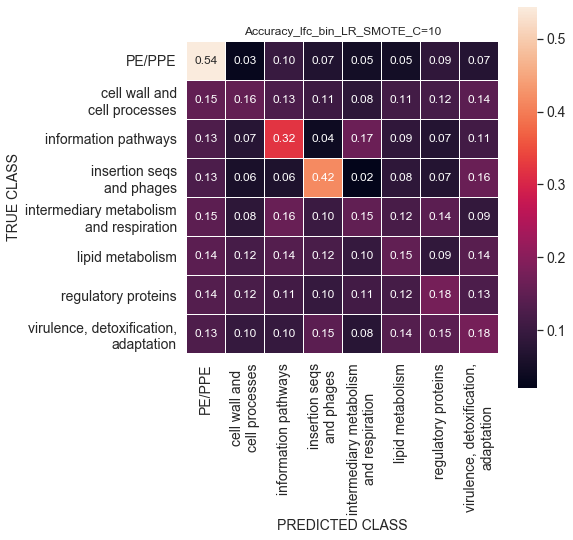

In [175]:
lasso_confusion(lfc_bin_mb, lfc_bin_cols, C=10, norm_method='SMOTE', name='Accuracy_lfc_bin_LR_SMOTE_C=10')